In [1]:
import glob
import numpy as np
from tqdm.notebook import tqdm
from tifffile import imread, imwrite
from skimage.measure import label
from metrics import remap_label
import matplotlib.pyplot as plt
import skimage
import scipy.ndimage as nd
from skimage.segmentation import watershed
from skimage.morphology import binary_closing, binary_opening, disk
from PIL import Image
import matplotlib
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

In [2]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 6
        }
padding = {
    'titlepad': 3,
    'labelpad': 1,
}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **padding)

In [3]:
np.random.seed(500)
rgb = np.random.random((300, 5))

In [4]:
data_path = '/data/duanb/EM/CREMI_A/'

In [5]:
def label2rgb(lab):
    lab_rgb = np.zeros((lab.shape[0], lab.shape[0], 3))
    for i in (np.unique(lab)):
        lab_rgb[lab == i] = rgb[i % rgb.shape[0], 2:]

    lab_rgb[lab == 0] = [0, 0, 0]

    return np.array(lab_rgb*255, np.uint8)

In [6]:
def boundary_to_color(img, ref):
    seeds, _ = nd.label( nd.binary_erosion( img > 0, iterations=2 ) )
    lab = watershed(-img, seeds)
    lab[img == 0] = 0
    lab = create_border_mask(lab, max_dist=0.5)
    print(len(np.unique(lab)))
    lab = remap(lab, ref)
    lab_im = label2rgb(lab)

    return lab_im

In [7]:
def create_border_mask(image, max_dist=1.25, background_label=0):
    """
    Create binary border mask for image.
    A pixel is part of a border if one of its 4-neighbors has different label.

    Parameters
    ----------
    image : numpy.ndarray - Image containing integer labels.
    max_dist : int or float - Maximum distance from border for pixels to be included into the mask.

    Returns
    -------
    mask : numpy.ndarray - Binary mask of border pixels. Same shape as image.
    """
    max_dist = max(max_dist, 0)
    target = image.copy()

    padded = np.pad(image, 1, mode='edge')

    border_pixels = np.logical_and(
        np.logical_and(image == padded[:-2, 1:-1], image == padded[2:, 1:-1]),
        np.logical_and(image == padded[1:-1, :-2], image == padded[1:-1, 2:])
    )

    distances = nd.distance_transform_edt(
        border_pixels,
        return_distances=True,
        return_indices=False
    )

    border = distances <= max_dist
    target[border] = background_label

    return target

In [8]:
def remap(lab, ref):
    re_lab = np.zeros_like(lab)
    for i in np.unique(lab):
        if i == 0:
            continue
        idx = np.bincount(ref[lab == i].flatten()).argmax()
        re_lab[lab == i] = idx

    return re_lab

In [9]:
def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3]
    not [0, 2, 4, 6]. The ordering of instances (which one comes first)
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    try:  # blinly remove background
        pred_id.remove(0)
    except ValueError:
        pass
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

In [10]:
img = np.logical_not(imread('CREMI_A/GT.tif'))
img = np.array(img, dtype=np.float32)
tmp = Image.fromarray(np.array(img*255, np.uint8))
tmp.save('CREMI_A/GT_reverse.png')
seeds, _ = nd.label( nd.binary_erosion( img > 0, iterations=2 ) )
lab = watershed(-img, seeds)
lab[img == 0] = 0
lab = create_border_mask(lab, max_dist=0.5)
lab = remap_label(lab)
ref = lab.copy()
lab = label2rgb(lab)
im = Image.fromarray(lab)
im.save('CREMI_A/GT_watershed.png')
print(len(np.unique(ref)))

394


In [11]:
img = np.logical_not(imread('CREMI_A/raw.tif'))
img = np.array(img, dtype=np.float32)
lab = boundary_to_color(img, ref)
im = Image.fromarray(lab)
im.save('CREMI_A/raw_watershed.png')

375


In [12]:
img = np.logical_not(imread('CREMI_A/EM_AV1_grain10_Q5_cs10_U_Net.tif'))
img = np.array(img, dtype=np.float32)
lab = boundary_to_color(img, ref)
im = Image.fromarray(lab)
im.save('CREMI_A/EM_AV1_grain10_Q5_cs10_U_Net_watershed.png')

370


In [13]:
img = np.logical_not(imread('CREMI_A/EM_AV1_grain10_Q26_cs30_U_Net.tif'))
img = np.array(img, dtype=np.float32)
lab = boundary_to_color(img, ref)
im = Image.fromarray(lab)
im.save('CREMI_A/EM_AV1_grain10_Q26_cs30_U_Net_watershed.png')

368


In [14]:
img = np.logical_not(imread('CREMI_A/EM_AV1_grain10_Q50_cs107_U_Net.tif'))
img = np.array(img, dtype=np.float32)
lab = boundary_to_color(img, ref)
im = Image.fromarray(lab)
im.save('CREMI_A/EM_AV1_grain10_Q50_cs107_U_Net_watershed.png')

306


In [4]:
def plot_mask(ax_handler, mask, img, bbox=[30, 512, 512, 512]):
    mask = np.array(mask)
    ax_handler.imshow(img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]], cmap='gray')
    ax_handler.imshow(mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]], alpha=0.6)

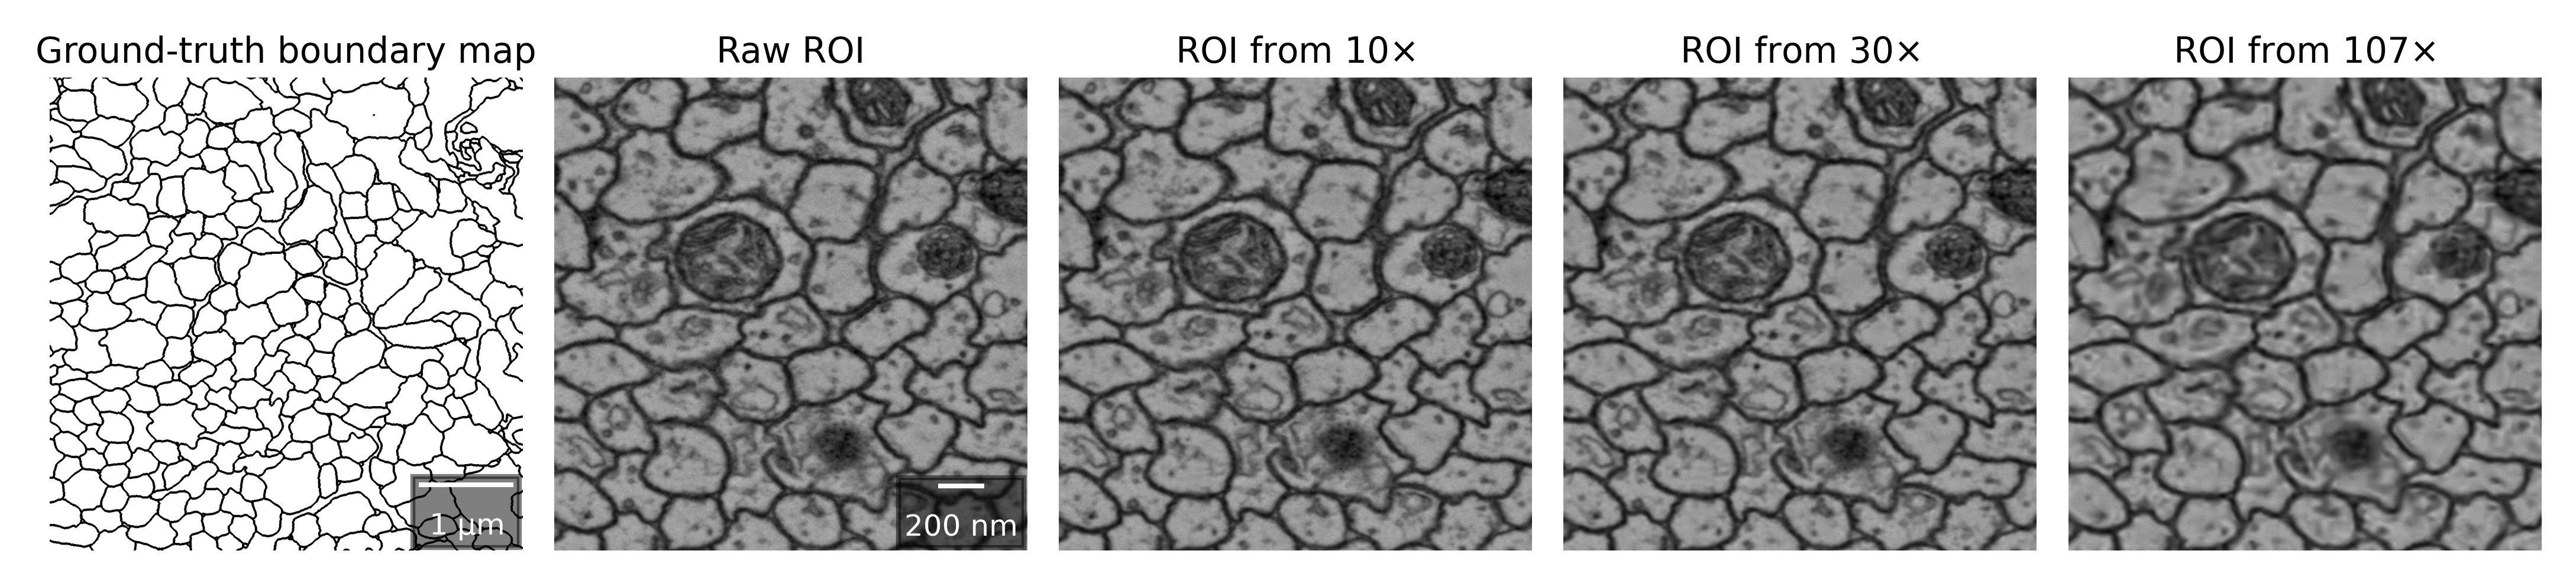

In [7]:
fig, axs = plt.subplots(figsize=(7.2, 2.6), dpi=600, ncols=5, nrows=1, layout='tight')

axs = axs.flat

for i, name in zip(range(5), ['Ground-truth boundary map', 'Raw ROI', 'ROI from 10$\\times$', 'ROI from 30$\\times$', 'ROI from 107$\\times$']):
    ax = axs[i]
    ax.set_title(name)
    ax.axis('off')


axs[0].imshow(imread('CREMI_A/GT.tif') == 0, cmap='gray')
axs[1].imshow(imread('CREMI_A/raw/raw.tif')[110, 512:1024, 30:542], cmap='gray', vmin=40, vmax=230)
axs[2].imshow(imread('CREMI_A/raw/EM_AV1_grain10_Q5_cs10.tif')[110, 512:1024, 30:542], cmap='gray', vmin=40, vmax=230)
axs[3].imshow(imread('CREMI_A/raw/EM_AV1_grain10_Q26_cs30.tif')[110, 512:1024, 30:542], cmap='gray', vmin=40, vmax=230)
axs[4].imshow(imread('CREMI_A/raw/EM_AV1_grain10_Q50_cs107.tif')[110, 512:1024, 30:542], cmap='gray', vmin=40, vmax=230)
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

axs[0].add_artist(ScaleBar(4, 'nm', location='lower right', box_color='k', box_alpha=0.5, color='w', width_fraction=0.01))
axs[1].add_artist(ScaleBar(4, 'nm', location='lower right', box_color='k', box_alpha=0.5, color='w', width_fraction=0.01))
plt.savefig('EM_results1.pdf', bbox_inches='tight')

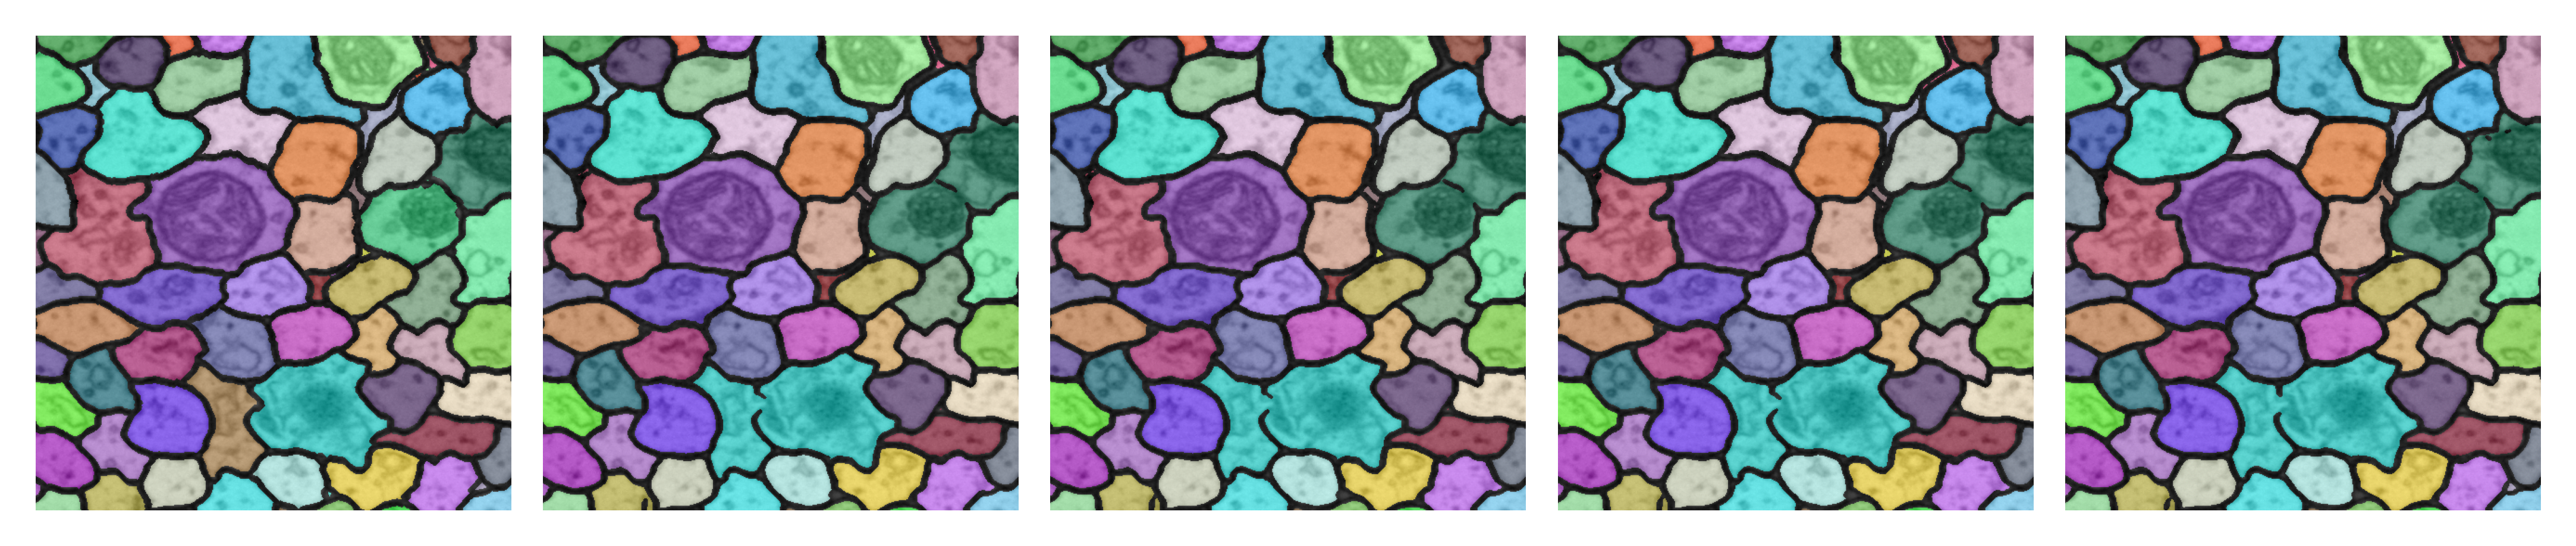

In [17]:
fig, axs = plt.subplots(figsize=(7.2, 2.4), dpi=600, ncols=5, nrows=1, layout='tight')

axs = axs.flat

for i, name in zip(range(5), ['Ground-truth\n segmentation', 'Segmentation for\nraw image', 'Segmentation for\n10$\\times$ compressed', 'Segmentation for\n80$\\times$ compressed', 'Segmentation for\n41$\\times$ compressed']):
    ax = axs[i]
    # ax.set_title(name)
    ax.axis('off')


dset1 = imread('CREMI_A/raw/raw.tif')[110, ...]
plot_mask(axs[0], Image.open('CREMI_A/GT_watershed.png'), dset1)
plot_mask(axs[1], Image.open('CREMI_A/raw_watershed.png'), dset1)
plot_mask(axs[2], Image.open('CREMI_A/EM_AV1_grain10_Q5_cs10_U_Net_watershed.png'), dset1)
plot_mask(axs[3], Image.open('CREMI_A/EM_AV1_grain10_Q26_cs30_U_Net_watershed.png'), dset1)
plot_mask(axs[4], Image.open('CREMI_A/EM_AV1_grain10_Q50_cs107_U_Net_watershed.png'), dset1)
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

plt.savefig('EM_results2.pdf', bbox_inches='tight')

In [6]:
data = pd.read_csv('CREMI_A/EM_stat_gt.csv')
data1 = data[data["Compression Method"].str.contains("grain10")]

data1['QFactor'] = data1.apply(lambda x: int(x['Compression Method'].split('_Q')[-1]), axis=1)

/tmp/ipykernel_802250/1472577709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['QFactor'] = data1.apply(lambda x: int(x['Compression Method'].split('_Q')[-1]), axis=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_802250/1704829852.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


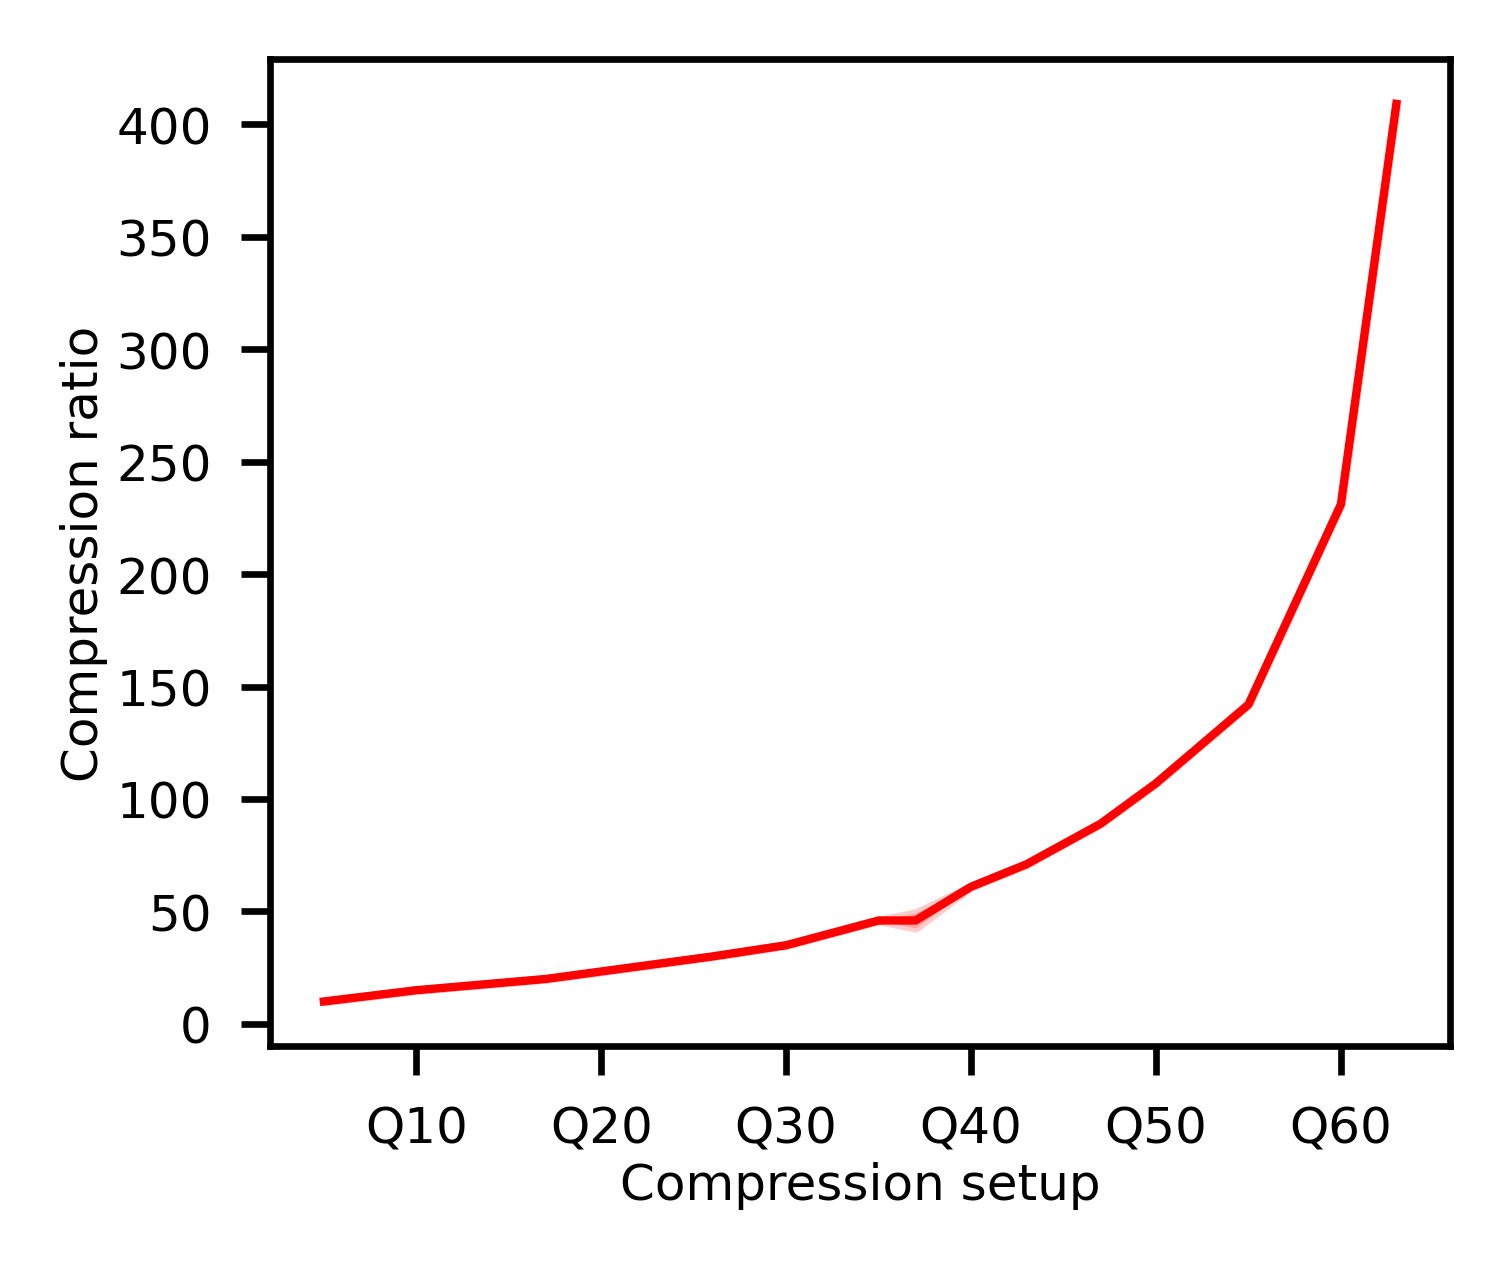

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2.4,2), dpi=600, layout='constrained')
sns.set_palette('muted')

sns.lineplot(data=data1, x="QFactor", y="Compressed Ratio", ax=ax, linewidth=1, color='r')

ax.legend(loc='upper left', frameon=False, fontsize=5)

labels = []
for i in [0, 10, 20, 30, 40, 50, 60]:
    labels.append(f'Q{i}')
ax.set_xticklabels(labels)

ax.set_xlabel('Compression setup')
ax.set_ylabel("Compression ratio")

fig.savefig('EM_error_part1.pdf')

In [3]:
data = pd.read_csv('CREMI_A/EM_stat_uncompressed.csv')

In [4]:
data['1 - ARAND'] = data.apply(
    lambda x: 1 - x['ARAND'], axis=1
)
data['1 - VOI_Merge'] = data.apply(
    lambda x: 1 - x['VOI_Merge'], axis=1
)
data['1 - VOI_Split'] = data.apply(
    lambda x: 1 - x['VOI_Split'], axis=1
)

In [5]:
data=data[data['Compressed Ratio'] < 110]
data

Unnamed: 0 Compression Method  Compressed Ratio      Model  FG_Dice   
0            0    AV1_grain10_Q10              15.0      U_Net      1.0  \
1            1    AV1_grain10_Q17              20.0      U_Net      1.0   
2            2    AV1_grain10_Q26              30.0      U_Net      1.0   
3            3    AV1_grain10_Q30              35.0      U_Net      1.0   
4            4    AV1_grain10_Q35              46.0      U_Net      1.0   
5            5    AV1_grain10_Q37              41.0      U_Net      1.0   
6            6    AV1_grain10_Q37              51.0      U_Net      1.0   
7            7    AV1_grain10_Q40              61.0      U_Net      1.0   
8            8    AV1_grain10_Q43              71.0      U_Net      1.0   
9            9    AV1_grain10_Q45              80.0      U_Net      1.0   
10          10    AV1_grain10_Q47              89.0      U_Net      1.0   
11          11    AV1_grain10_Q50             107.0      U_Net      1.0   
13          13     AV1_grain10_Q5              10.0      U_Net      1.0   
16          16    AV1_grain10_Q10              15.0   UNetplus      1.0   
17          17    AV1_grain10_Q17              20.0   UNetplus      1.0   
18          18    AV1_grain10_Q26              30.0   UNetplus      1.0   
19          19    AV1_grain10_Q30              35.0   UNetplus      1.0   
20          20    AV1_grain10_Q35              46.0   UNetplus      1.0   
21          21    AV1_grain10_Q37              41.0   UNetplus      1.0   
22          22    AV1_grain10_Q37              51.0   UNetplus      1.0   
23          23    AV1_grain10_Q40              61.0   UNetplus      1.0   
24          24    AV1_grain10_Q43              71.0   UNetplus      1.0   
25          25    AV1_grain10_Q45              80.0   UNetplus      1.0   
26          26    AV1_grain10_Q47              89.0   UNetplus      1.0   
27          27    AV1_grain10_Q50             107.0   UNetplus      1.0   
29          29     AV1_grain10_Q5              10.0   UNetplus      1.0   
32          32    AV1_grain10_Q10              15.0  TransUnet      1.0   
33          33    AV1_grain10_Q17              20.0  TransUnet      1.0   
34          34    AV1_grain10_Q26              30.0  TransUnet      1.0   
35          35    AV1_grain10_Q30              35.0  TransUnet      1.0   
36          36    AV1_grain10_Q35              46.0  TransUnet      1.0   
37          37    AV1_grain10_Q37              41.0  TransUnet      1.0   
38          38    AV1_grain10_Q37              51.0  TransUnet      1.0   
39          39    AV1_grain10_Q40              61.0  TransUnet      1.0   
40          40    AV1_grain10_Q43              71.0  TransUnet      1.0   
41          41    AV1_grain10_Q45              80.0  TransUnet      1.0   
42          42    AV1_grain10_Q47              89.0  TransUnet      1.0   
43          43    AV1_grain10_Q50             107.0  TransUnet      1.0   
45          45     AV1_grain10_Q5              10.0  TransUnet      1.0   

       ARAND  VOI_Merge  VOI_Split  1 - ARAND  1 - VOI_Merge  1 - VOI_Split  
0   0.020062   0.002905   0.003850   0.979938       0.997095       0.996150  
1   0.021210   0.003209   0.004952   0.978790       0.996791       0.995048  
2   0.028402   0.004368   0.006239   0.971598       0.995632       0.993761  
3   0.034258   0.005071   0.006994   0.965742       0.994929       0.993006  
4   0.039876   0.006731   0.008567   0.960124       0.993269       0.991433  
5   0.043443   0.007472   0.009090   0.956557       0.992528       0.990910  
6   0.043443   0.007472   0.009091   0.956557       0.992528       0.990909  
7   0.053916   0.008888   0.010493   0.946084       0.991112       0.989507  
8   0.053493   0.010389   0.010747   0.946507       0.989611       0.989253  
9   0.057333   0.011650   0.011438   0.942667       0.988350       0.988562  
10  0.062601   0.013102   0.012442   0.937399       0.986898       0.987558  
11  0.086962   0.016569   0.013786   0.913038       0.983431       

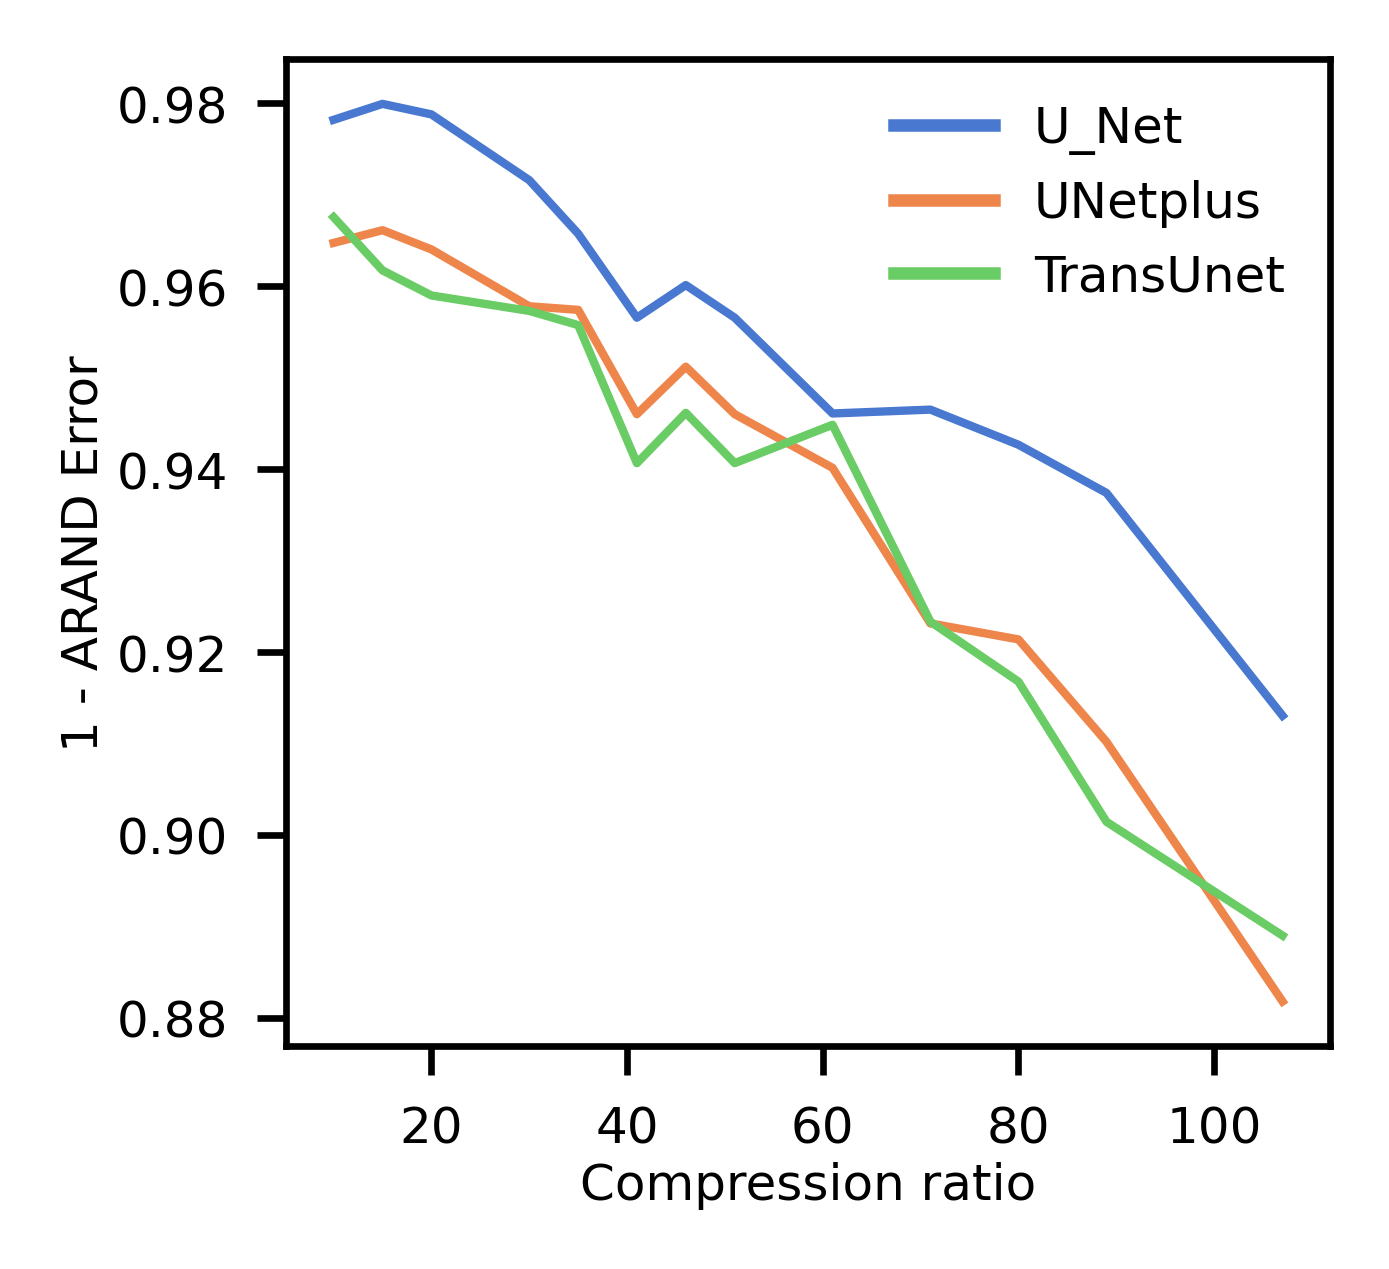

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2.2,2), dpi=600, layout='constrained')
sns.set_palette('muted')

sns.lineplot(data=data, x="Compressed Ratio", y="1 - ARAND",  hue='Model', ax=ax, linewidth=1)

ax.legend(frameon=False)
ax.set_xlabel('Compression ratio')
ax.set_ylabel("1 - ARAND Error")

fig.savefig('EM_error_part2.pdf')

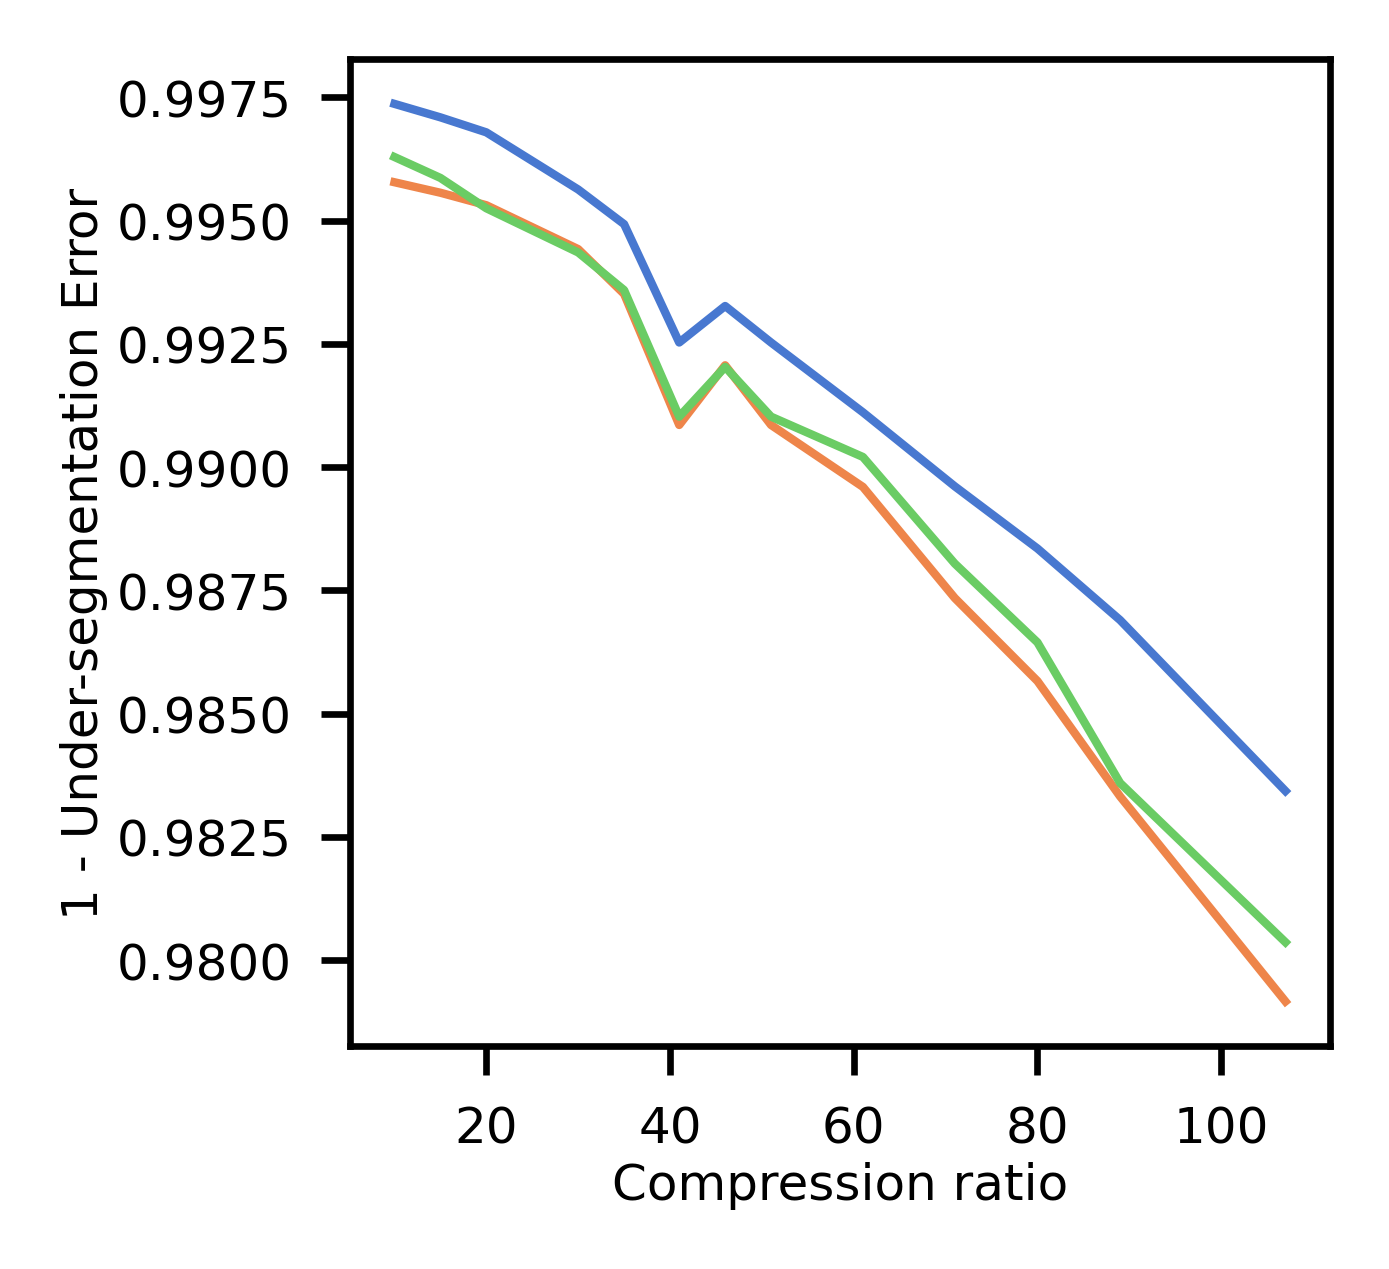

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2.2,2), dpi=600, layout='constrained')
sns.set_palette('muted')

sns.lineplot(data=data, x="Compressed Ratio", y="1 - VOI_Merge",  hue='Model', ax=ax, linewidth=1)

ax.legend(frameon=False)
ax.set_xlabel('Compression ratio')
ax.set_ylabel("1 - Under-segmentation Error")
ax.legend().remove()
fig.savefig('EM_error_part3.pdf')

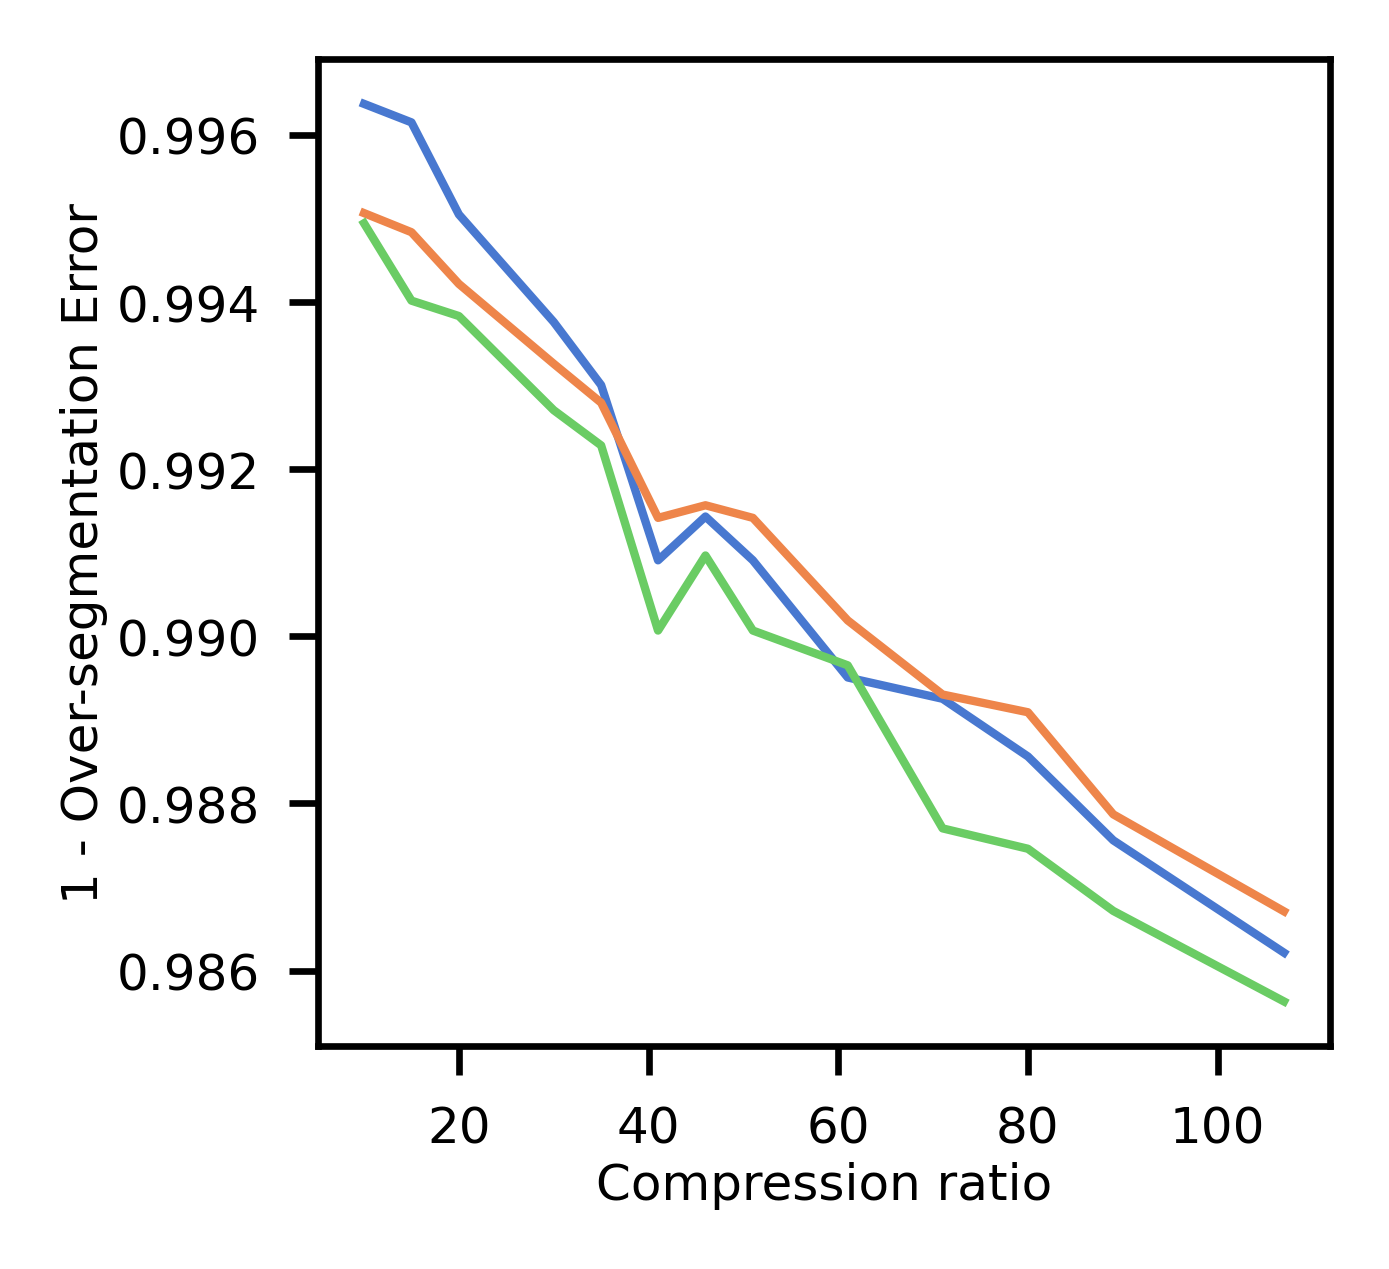

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2.2,2), dpi=600, layout='constrained')
sns.set_palette('muted')

sns.lineplot(data=data, x="Compressed Ratio", y="1 - VOI_Split",  hue='Model', ax=ax, linewidth=1)

ax.legend(frameon=False)
ax.set_xlabel('Compression ratio')
ax.set_ylabel("1 - Over-segmentation Error")
ax.legend().remove()
fig.savefig('EM_error_part4.pdf')